In [1]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import src.data.preprocessor as pre
import src.data.datasets as data
from src.model.CNN import create_DCNN, create_MQDCNN, MultiQuantileLoss
from src.utils import compute_coverage_len, compute_quantile, compute_quantiles_nex, validate_calibration_epoch, reform_test_data, plot_sorted_targets_intervals, plot_validate_calibration, PHM_score

In [3]:
import os
#in order not to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

# Training: 
1. train a DCNN for each dataset separately 
2. train a MQDCNN for each dataset separately
3. save the preprocessed data as well as trained models

In [4]:
#CMAPSS data removable and ignorable cols
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
ignore_columns = ["time", "os1", "os2", "os3"]

epochs = 250 #training epochs for both DCNN and MQDCNN 
optimizer = Adam(learning_rate=1e-3) #model optimizer
alpha = 0.1 #miscoverage rate
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

#MQDCNN related parameters
quantiles = [alpha, 1 - alpha]
loss_func = MultiQuantileLoss(quantiles=quantiles)

trained_models_dic = {}
for exp in range(4):
    #load, split, and preprocess a dataset from CMAPSS datasets
    dataset_name = "CMAPSS"+str(exp+1)
    dataset = data.get_dataset(dataset_name, MinMaxScaler(feature_range=(-1, 1)))
    split_dataset = pre.split_dataset(dataset, calval_size=0.1, random_state=0)
    proc_dataset = pre.preprocess_split(split_dataset, scaler_factory=dataset["scaler_factory"], window_size=dataset["window_size"], removable_cols=removable_cols, ignore_columns=ignore_columns)

    X_train = proc_dataset["train"]["X"]
    y_train = proc_dataset["train"]["y"]
    X_calval = proc_dataset["calval"]["X"]
    y_calval = proc_dataset["calval"]["y"]
    #DCNN training
    DCNN = create_DCNN(window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
    DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    DCNN_hist = DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs, validation_data=(X_calval, y_calval), callbacks=[callback])
    DCNN.save('saved_models\\DCNN\\'+dataset_name)  
    #MQDCNN training
    MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
    MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
    MQDCNN_hist = MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs, validation_data=(X_calval, y_calval), callbacks=[callback])
    MQDCNN.save('saved_models\\MQDCNN\\'+dataset_name)
    trained_models_dic[dataset_name] = {
        "data": proc_dataset,
        "DCNN": DCNN,
        "MQDCNN": MQDCNN,
        "DCNN_hist": DCNN_hist, 
        "MQDCNN_hist": MQDCNN_hist
    }

Epoch 1/250
31/31 [==============================] - 7s 192ms/step - loss: 6631.6445 - root_mean_squared_error: 81.4349 - val_loss: 6509.2524 - val_root_mean_squared_error: 80.6799
Epoch 2/250
31/31 [==============================] - 5s 165ms/step - loss: 5703.7583 - root_mean_squared_error: 75.5232 - val_loss: 6003.4590 - val_root_mean_squared_error: 77.4820
Epoch 3/250
31/31 [==============================] - 5s 163ms/step - loss: 5283.4072 - root_mean_squared_error: 72.6870 - val_loss: 5588.9243 - val_root_mean_squared_error: 74.7591
Epoch 4/250
31/31 [==============================] - 5s 162ms/step - loss: 4911.0322 - root_mean_squared_error: 70.0788 - val_loss: 5209.3218 - val_root_mean_squared_error: 72.1756
Epoch 5/250
31/31 [==============================] - 5s 164ms/step - loss: 4569.8091 - root_mean_squared_error: 67.6004 - val_loss: 4858.8950 - val_root_mean_squared_error: 69.7058
Epoch 6/250
31/31 [==============================] - 5s 162ms/step - loss: 4254.4160 - root_mea

INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS1\assets


INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS1\assets


Epoch 1/250
31/31 [==============================] - 6s 161ms/step - loss: 64.0103 - q0_loss: 7.4355 - q1_loss: 56.5748 - q0_root_mean_squared_error: 82.5648 - q1_root_mean_squared_error: 74.5156 - val_loss: 59.3228 - val_q0_loss: 7.5297 - val_q1_loss: 51.7932 - val_q0_root_mean_squared_error: 79.6439 - val_q1_root_mean_squared_error: 69.0852
Epoch 2/250
31/31 [==============================] - 5s 149ms/step - loss: 50.4120 - q0_loss: 7.1937 - q1_loss: 43.2183 - q0_root_mean_squared_error: 75.0250 - q1_root_mean_squared_error: 60.5218 - val_loss: 49.3209 - val_q0_loss: 7.5200 - val_q1_loss: 41.8009 - val_q0_root_mean_squared_error: 78.7494 - val_q1_root_mean_squared_error: 58.4995
Epoch 3/250
31/31 [==============================] - 5s 149ms/step - loss: 42.4819 - q0_loss: 7.1930 - q1_loss: 35.2889 - q0_root_mean_squared_error: 75.8962 - q1_root_mean_squared_error: 52.4072 - val_loss: 42.6490 - val_q0_loss: 7.5263 - val_q1_loss: 35.1227 - val_q0_root_mean_squared_error: 79.4122 - val_q

INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS1\assets


INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS1\assets


Epoch 1/250
87/87 [==============================] - 10s 107ms/step - loss: 4529.3638 - root_mean_squared_error: 67.3005 - val_loss: 2772.0076 - val_root_mean_squared_error: 52.6499
Epoch 2/250
87/87 [==============================] - 9s 104ms/step - loss: 2417.7903 - root_mean_squared_error: 49.1710 - val_loss: 2010.8503 - val_root_mean_squared_error: 44.8425
Epoch 3/250
87/87 [==============================] - 9s 107ms/step - loss: 1931.4303 - root_mean_squared_error: 43.9480 - val_loss: 1777.6167 - val_root_mean_squared_error: 42.1618
Epoch 4/250
87/87 [==============================] - 9s 107ms/step - loss: 1733.2152 - root_mean_squared_error: 41.6319 - val_loss: 1625.6302 - val_root_mean_squared_error: 40.3191
Epoch 5/250
87/87 [==============================] - 9s 107ms/step - loss: 1608.2253 - root_mean_squared_error: 40.1027 - val_loss: 1547.0144 - val_root_mean_squared_error: 39.3321
Epoch 6/250
87/87 [==============================] - 9s 107ms/step - loss: 1542.7916 - root_me

INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS2\assets


INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS2\assets


Epoch 1/250
87/87 [==============================] - 11s 120ms/step - loss: 56.0751 - q0_loss: 7.5447 - q1_loss: 48.5304 - q0_root_mean_squared_error: 80.2551 - q1_root_mean_squared_error: 66.7095 - val_loss: 40.5524 - val_q0_loss: 7.2667 - val_q1_loss: 33.2857 - val_q0_root_mean_squared_error: 75.1878 - val_q1_root_mean_squared_error: 50.3487
Epoch 2/250
87/87 [==============================] - 9s 107ms/step - loss: 35.3738 - q0_loss: 7.4103 - q1_loss: 27.9635 - q0_root_mean_squared_error: 76.8386 - q1_root_mean_squared_error: 46.0761 - val_loss: 28.5315 - val_q0_loss: 7.2470 - val_q1_loss: 21.2845 - val_q0_root_mean_squared_error: 74.9912 - val_q1_root_mean_squared_error: 42.1071
Epoch 3/250
87/87 [==============================] - 9s 107ms/step - loss: 25.9762 - q0_loss: 7.3921 - q1_loss: 18.5840 - q0_root_mean_squared_error: 76.7331 - q1_root_mean_squared_error: 41.9250 - val_loss: 21.7133 - val_q0_loss: 7.2310 - val_q1_loss: 14.4823 - val_q0_root_mean_squared_error: 75.0366 - val_

INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS2\assets


INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS2\assets


Epoch 1/250
38/38 [==============================] - 7s 159ms/step - loss: 6335.2598 - root_mean_squared_error: 79.5943 - val_loss: 5576.9692 - val_root_mean_squared_error: 74.6791
Epoch 2/250
38/38 [==============================] - 6s 150ms/step - loss: 3974.1082 - root_mean_squared_error: 63.0405 - val_loss: 3844.6321 - val_root_mean_squared_error: 62.0051
Epoch 3/250
38/38 [==============================] - 6s 151ms/step - loss: 2822.7944 - root_mean_squared_error: 53.1300 - val_loss: 2865.9180 - val_root_mean_squared_error: 53.5343
Epoch 4/250
38/38 [==============================] - 6s 148ms/step - loss: 2134.8342 - root_mean_squared_error: 46.2043 - val_loss: 2212.7383 - val_root_mean_squared_error: 47.0398
Epoch 5/250
38/38 [==============================] - 6s 147ms/step - loss: 1669.5869 - root_mean_squared_error: 40.8606 - val_loss: 1749.6984 - val_root_mean_squared_error: 41.8294
Epoch 6/250
38/38 [==============================] - 6s 147ms/step - loss: 1345.9061 - root_mea

INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS3\assets


INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS3\assets


Epoch 1/250
38/38 [==============================] - 7s 173ms/step - loss: 69.8682 - q0_loss: 8.0581 - q1_loss: 61.8101 - q0_root_mean_squared_error: 88.4636 - q1_root_mean_squared_error: 79.4409 - val_loss: 66.7527 - val_q0_loss: 8.0077 - val_q1_loss: 58.7449 - val_q0_root_mean_squared_error: 85.9018 - val_q1_root_mean_squared_error: 74.2168
Epoch 2/250
38/38 [==============================] - 6s 155ms/step - loss: 53.1299 - q0_loss: 6.8536 - q1_loss: 46.2763 - q0_root_mean_squared_error: 74.7377 - q1_root_mean_squared_error: 62.2446 - val_loss: 53.5188 - val_q0_loss: 6.7875 - val_q1_loss: 46.7313 - val_q0_root_mean_squared_error: 75.2848 - val_q1_root_mean_squared_error: 60.4807
Epoch 3/250
38/38 [==============================] - 6s 147ms/step - loss: 42.8277 - q0_loss: 5.9619 - q1_loss: 36.8657 - q0_root_mean_squared_error: 65.9911 - q1_root_mean_squared_error: 51.3144 - val_loss: 44.3392 - val_q0_loss: 6.0036 - val_q1_loss: 38.3355 - val_q0_root_mean_squared_error: 67.2262 - val_q

INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS3\assets


INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS3\assets


Epoch 1/250
102/102 [==============================] - 9s 86ms/step - loss: 4961.9194 - root_mean_squared_error: 70.4409 - val_loss: 3062.3718 - val_root_mean_squared_error: 55.3387
Epoch 2/250
102/102 [==============================] - 9s 87ms/step - loss: 2490.4871 - root_mean_squared_error: 49.9048 - val_loss: 2094.2056 - val_root_mean_squared_error: 45.7625
Epoch 3/250
102/102 [==============================] - 9s 87ms/step - loss: 1931.4756 - root_mean_squared_error: 43.9486 - val_loss: 1813.0970 - val_root_mean_squared_error: 42.5805
Epoch 4/250
102/102 [==============================] - 9s 87ms/step - loss: 1761.3757 - root_mean_squared_error: 41.9687 - val_loss: 1726.0637 - val_root_mean_squared_error: 41.5459
Epoch 5/250
102/102 [==============================] - 9s 88ms/step - loss: 1708.9863 - root_mean_squared_error: 41.3399 - val_loss: 1700.2593 - val_root_mean_squared_error: 41.2342
Epoch 6/250
102/102 [==============================] - 9s 87ms/step - loss: 1693.5161 - ro

INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS4\assets


INFO:tensorflow:Assets written to: saved_models\DCNN\CMAPSS4\assets


Epoch 1/250
102/102 [==============================] - 11s 98ms/step - loss: 61.4553 - q0_loss: 8.1718 - q1_loss: 53.2835 - q0_root_mean_squared_error: 84.5987 - q1_root_mean_squared_error: 70.6635 - val_loss: 45.9178 - val_q0_loss: 7.9851 - val_q1_loss: 37.9327 - val_q0_root_mean_squared_error: 79.3456 - val_q1_root_mean_squared_error: 53.5529
Epoch 2/250
102/102 [==============================] - 9s 88ms/step - loss: 38.0916 - q0_loss: 7.9976 - q1_loss: 30.0941 - q0_root_mean_squared_error: 79.6165 - q1_root_mean_squared_error: 46.9480 - val_loss: 31.2573 - val_q0_loss: 7.9851 - val_q1_loss: 23.2722 - val_q0_root_mean_squared_error: 79.7775 - val_q1_root_mean_squared_error: 42.2893
Epoch 3/250
102/102 [==============================] - 9s 86ms/step - loss: 26.5793 - q0_loss: 7.9969 - q1_loss: 18.5825 - q0_root_mean_squared_error: 79.6309 - q1_root_mean_squared_error: 41.4147 - val_loss: 22.2254 - val_q0_loss: 7.9851 - val_q1_loss: 14.2403 - val_q0_root_mean_squared_error: 79.6720 - v

INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS4\assets


INFO:tensorflow:Assets written to: saved_models\MQDCNN\CMAPSS4\assets


# Plot training and validation history

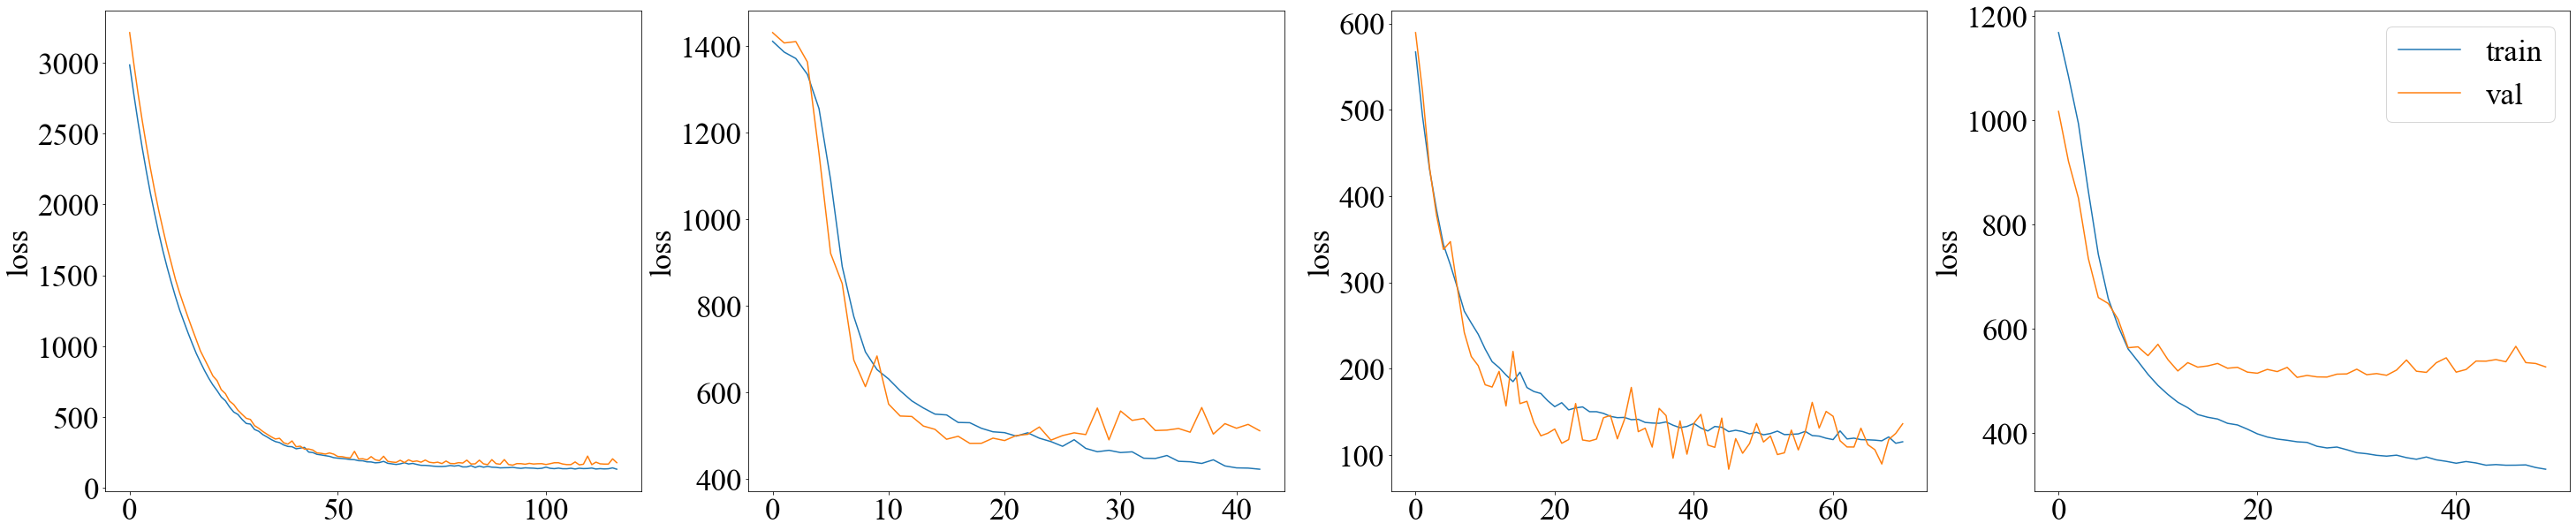

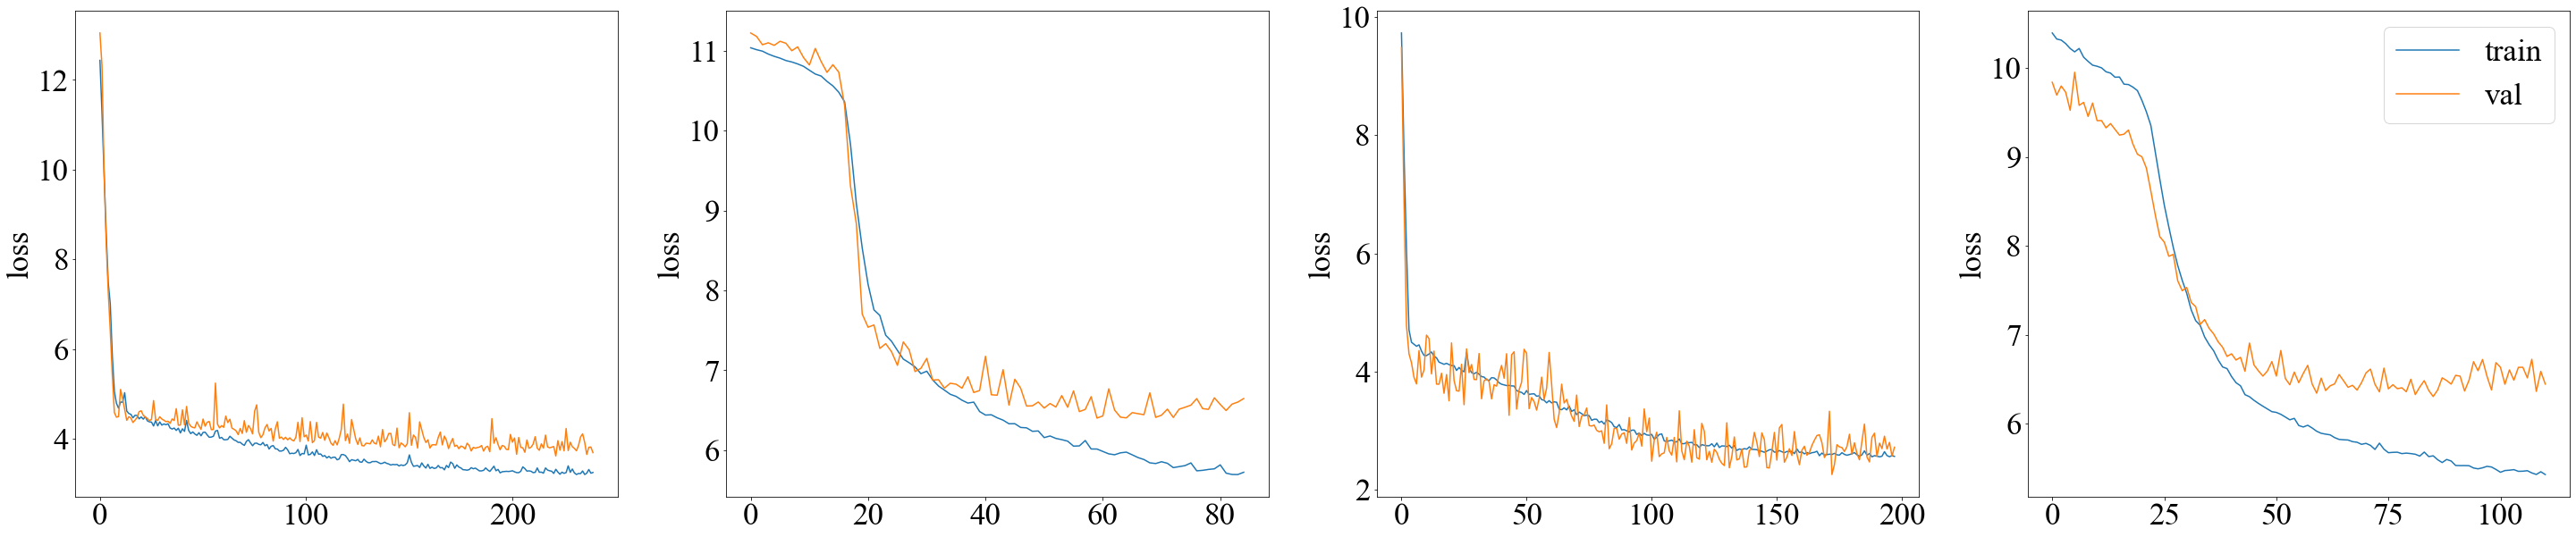

In [115]:
from cProfile import label


for m in ["DCNN_hist","MQDCNN_hist"]:
    fig = plt.figure(figsize=(50, 10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 35
    for exp in range(4):
        ax = fig.add_subplot(1,4,exp+1)
        dataset_name = "CMAPSS"+str(exp+1)
        ax.plot(trained_models_dic[dataset_name][m].history['loss'][10:], label='train')
        ax.plot(trained_models_dic[dataset_name][m].history['val_loss'][10:], label='val')
        plt.ylabel("loss")
    plt.legend(loc='upper right')
    plt.savefig('result_figs\\training\\'+m+'.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
    

# Validate the performance of calibration
1. Split calibration+validation data into cal and val subsets randomly 
2. calibrate on cal and test it on val
3. check the coverage and interval lengths for each CP method (i.e., SCP, nex-SCP, and CQR)
4. repeat the process R times for each dataset and save the results 

In [20]:
R = 50
rho = 0.99
alpha = 0.1

validate_calibration_res = {}
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    proc_data, DCNN, MQDCNN = trained_models_dic[dataset_name]["data"], trained_models_dic[dataset_name]["DCNN"], trained_models_dic[dataset_name]["MQDCNN"]
    res = [] #each element contain SCP, nex-SCP, CQR results
    for r in range(R):
        val_idx, cal_idx = pre.split_by_group(X=proc_data["calval"]["X"], groups=proc_data["calval"]["id"], n_splits=1, test_size=0.5, random_state=r)
        res.append(validate_calibration_epoch(proc_data["calval"], val_idx, cal_idx, DCNN, MQDCNN, alpha, rho))
    SCP, nex_SCP, CQR =  zip(*res)
    validate_calibration_res[dataset_name] = {
        "SCP": SCP,
        "nex-SCP": nex_SCP,
        "CQR": CQR
    }

In [120]:
import sys, importlib
importlib.reload(sys.modules['src.utils'])
from src.utils import plot_validate_calibration, plot_sorted_targets_intervals, PHM_score

# Plot the histograms of the followings:
1. average lower bound coverage
2. average coverage
3. average interval length for each method

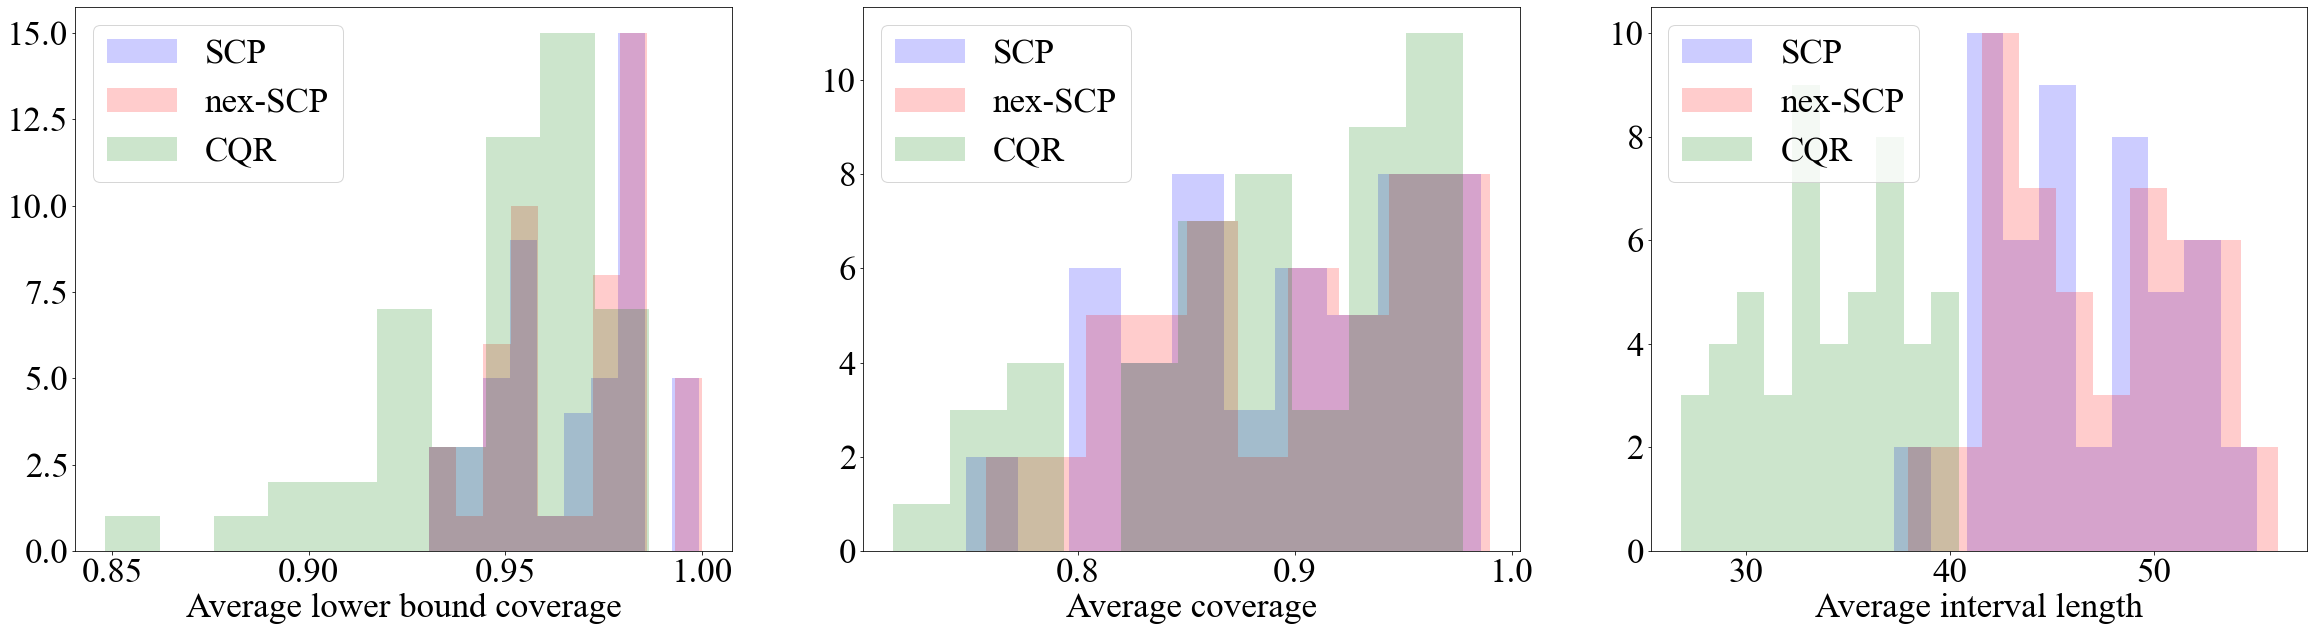

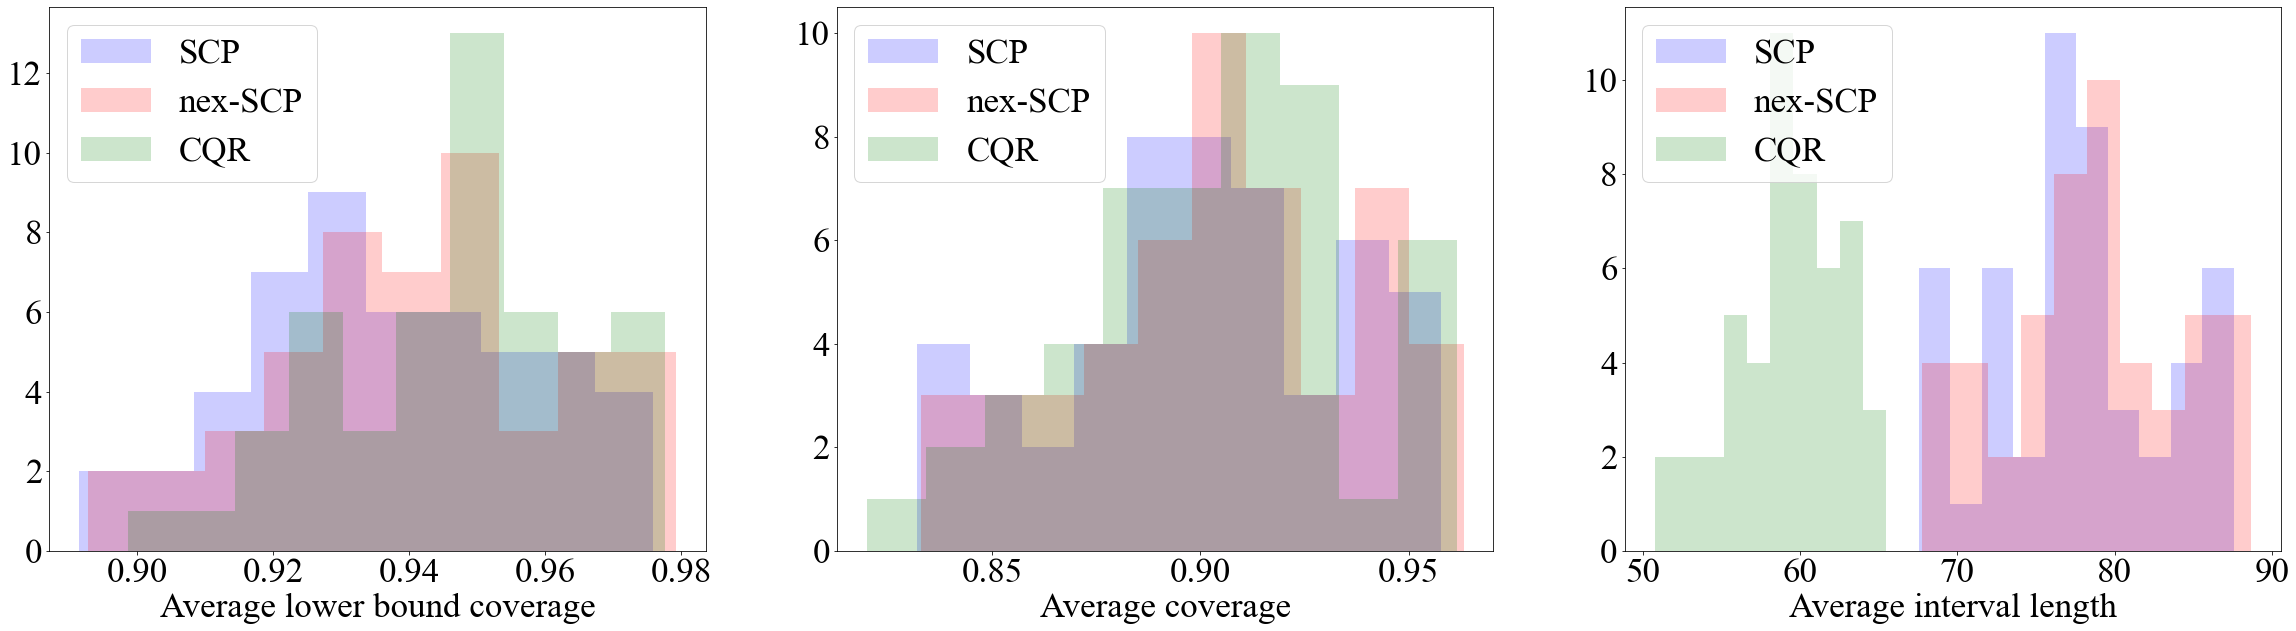

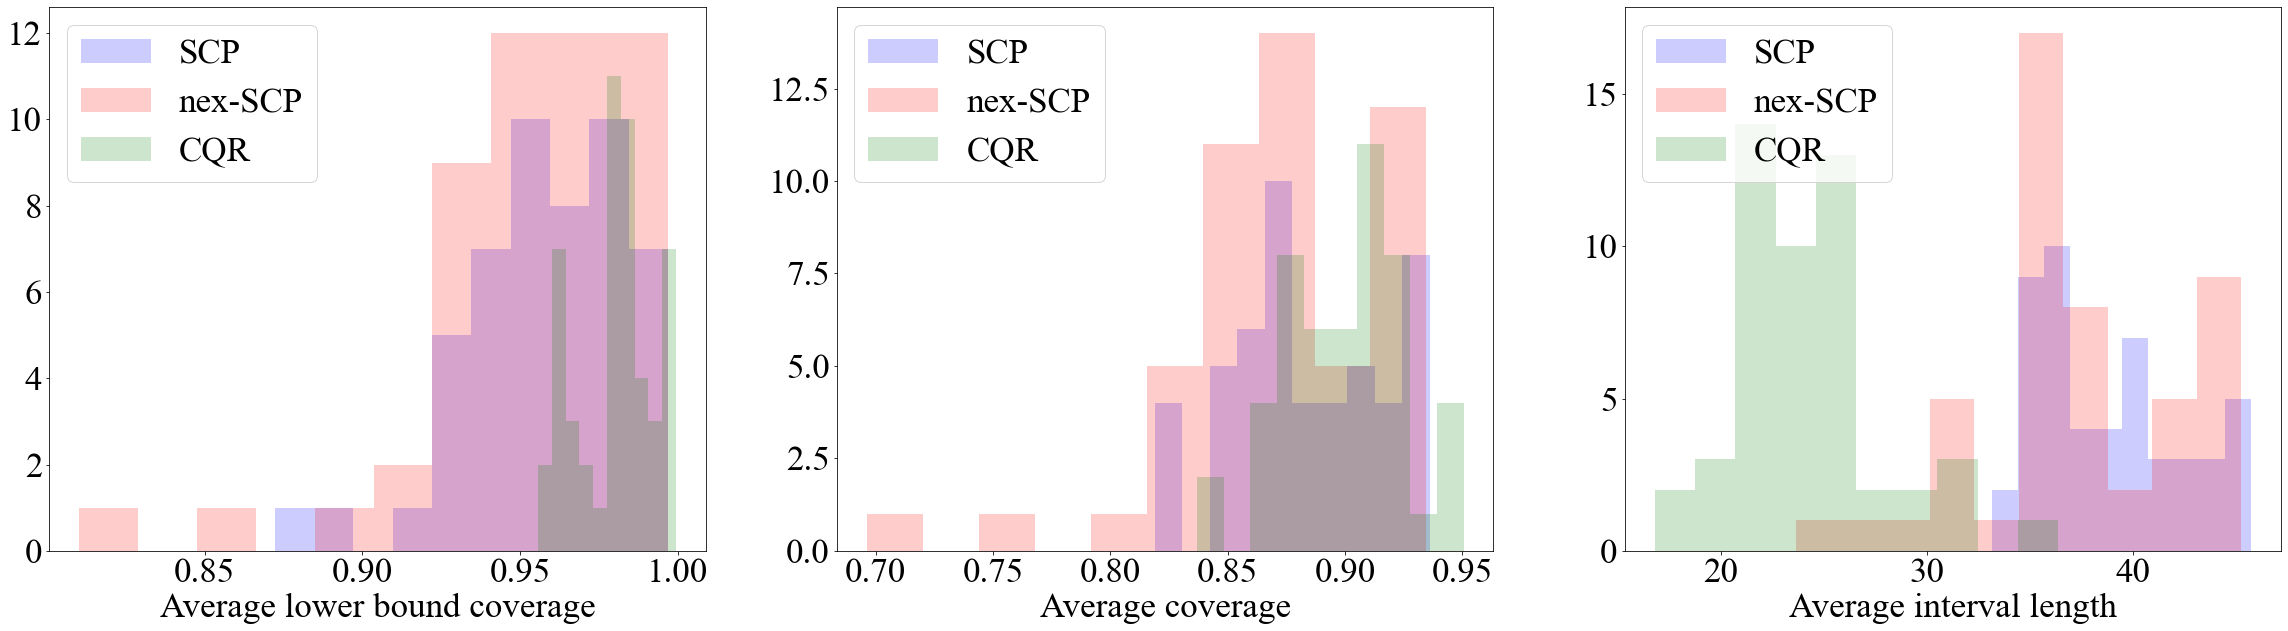

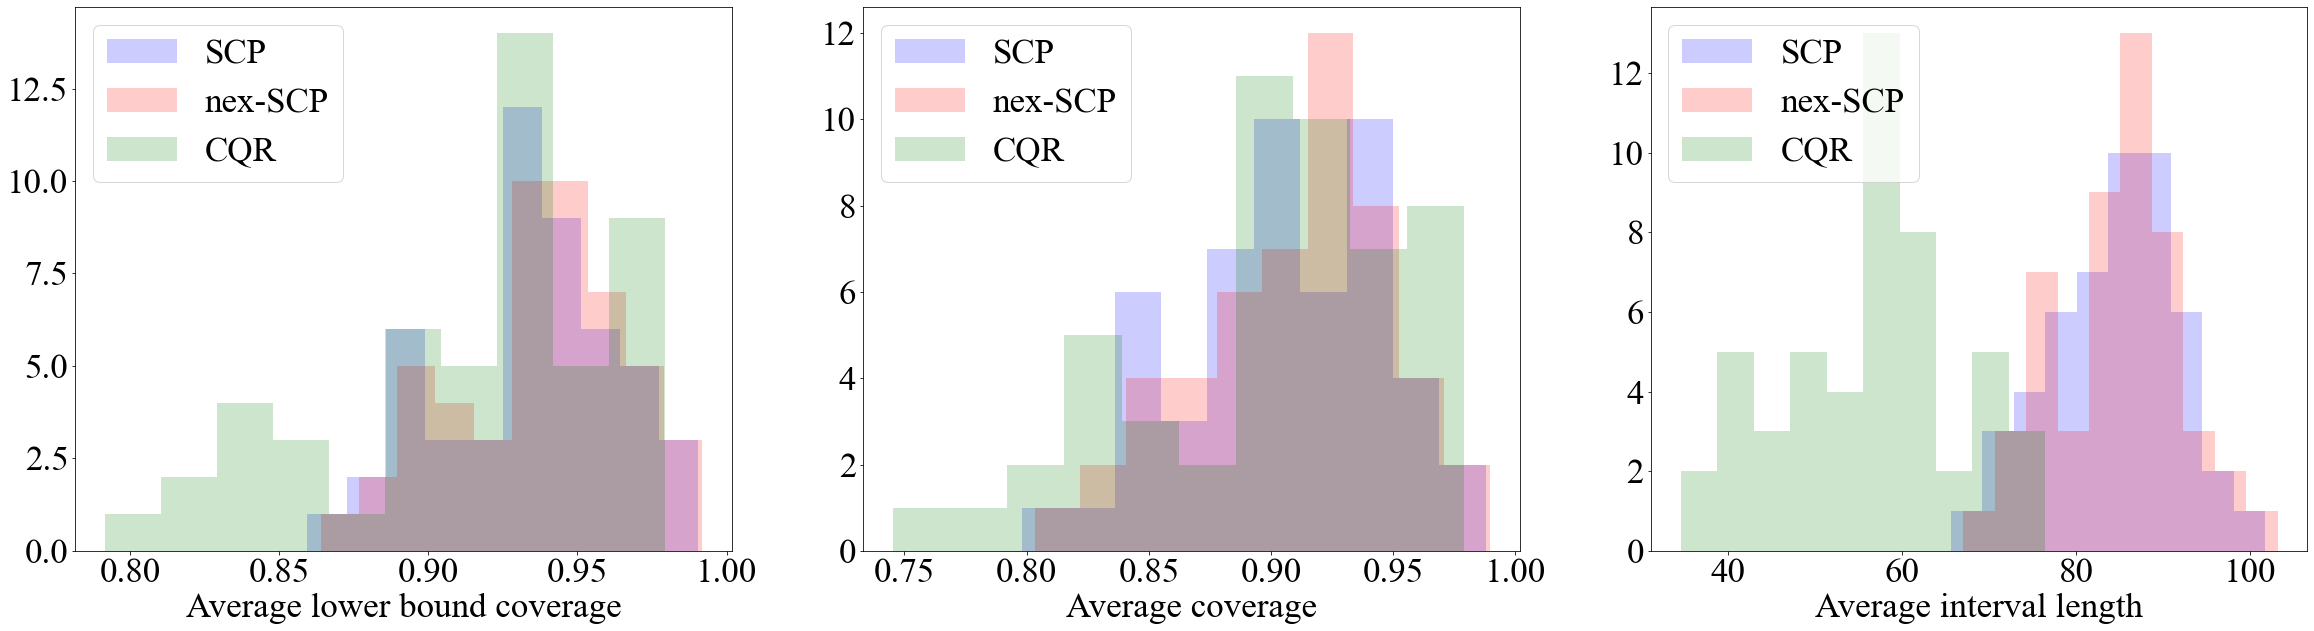

In [117]:
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    plot_validate_calibration(dataset_name, validate_calibration_res)
    plt.savefig('result_figs\\validate_calibration\\'+dataset_name+'.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# One-time calibration and test 
for each dataset and each methods, use calibration+validation data to calibrate and test it on test

In [22]:
test_res = {}
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    proc_data, DCNN, MQDCNN = trained_models_dic[dataset_name]["data"], trained_models_dic[dataset_name]["DCNN"], trained_models_dic[dataset_name]["MQDCNN"]
    X_cal, y_cal, idx_cal = proc_data["calval"]["X"], proc_data["calval"]["y"], proc_data["calval"]["index"]
    X_test, y_test, idx_test = reform_test_data(proc_data["test"])

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_test = DCNN.predict(x=X_test, verbose=0)
    scores = np.abs(y_cal - y_hat_cal) 
    q = compute_quantile(scores, alpha)
    q_array = compute_quantiles_nex(rho, scores, idx_test, idx_cal, alpha)

    y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
    y_hat_test_CQR = MQDCNN.predict(x=X_test, verbose=0)
    scores_low = y_hat_cal_CQR[0] - y_cal
    scores_high = y_cal - y_hat_cal_CQR[1] 
    scores_CQR = np.maximum(scores_low, scores_high)
    q_CQR = compute_quantile(scores_CQR, alpha)

    test_res[dataset_name] = {
        "y_test": y_test,
        "SCP": (np.maximum(0,y_hat_test - q), y_hat_test + q),
        "nex-SCP": (np.maximum(0, y_hat_test  - q_array), y_hat_test  + q_array),
        "CQR": (np.maximum(0, y_hat_test_CQR[0] - q_CQR), y_hat_test_CQR[1] + q_CQR)
    }

# Plot test results and save them 


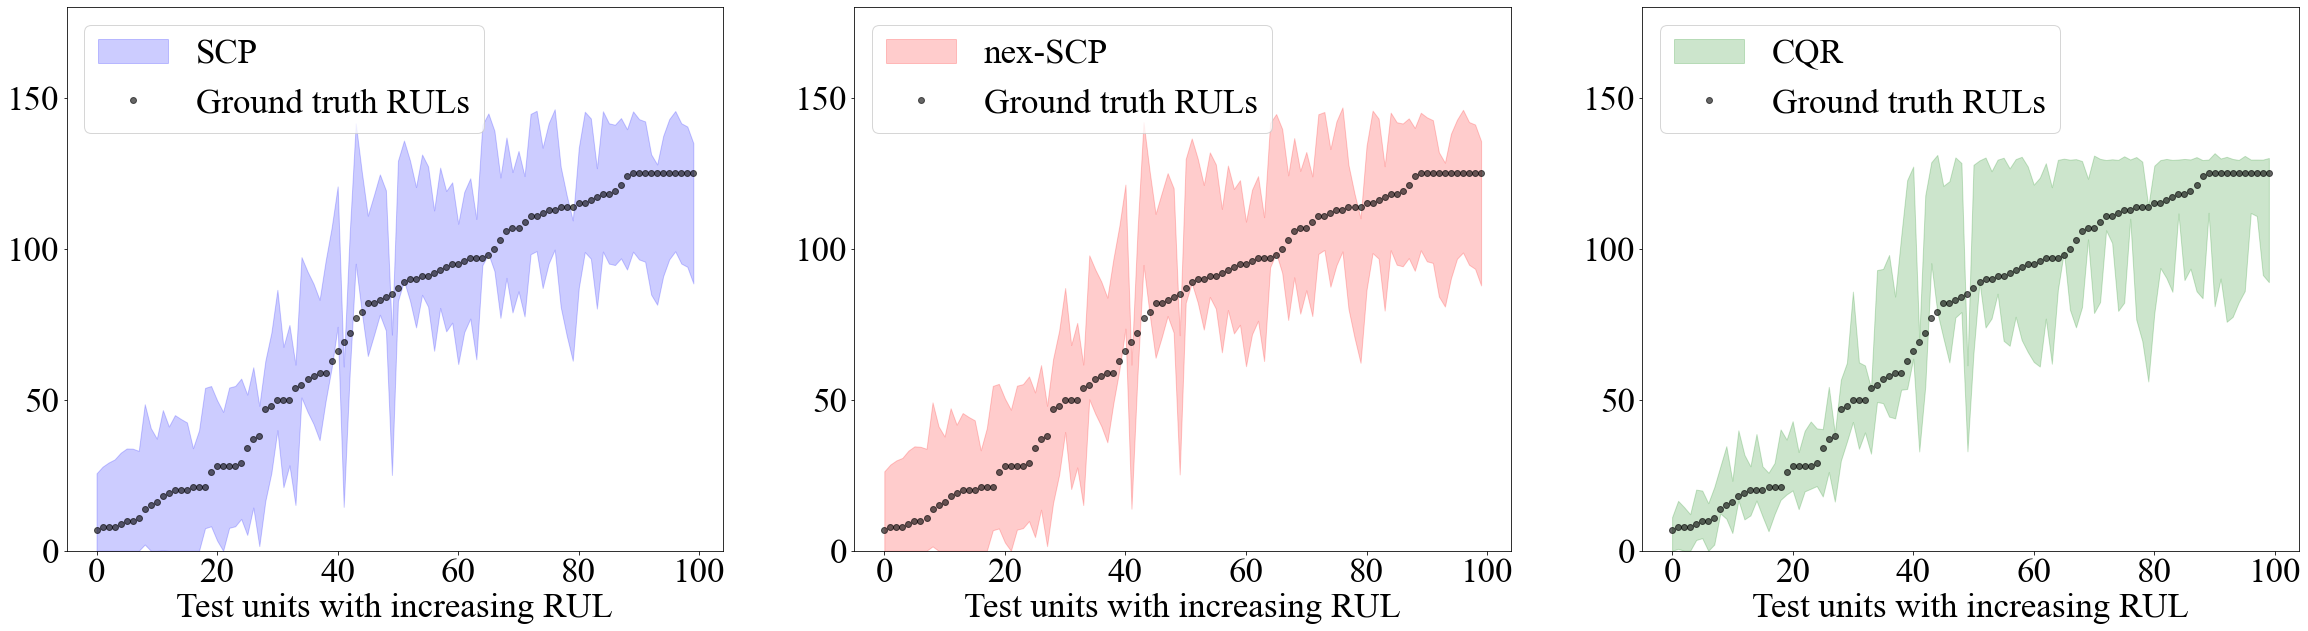

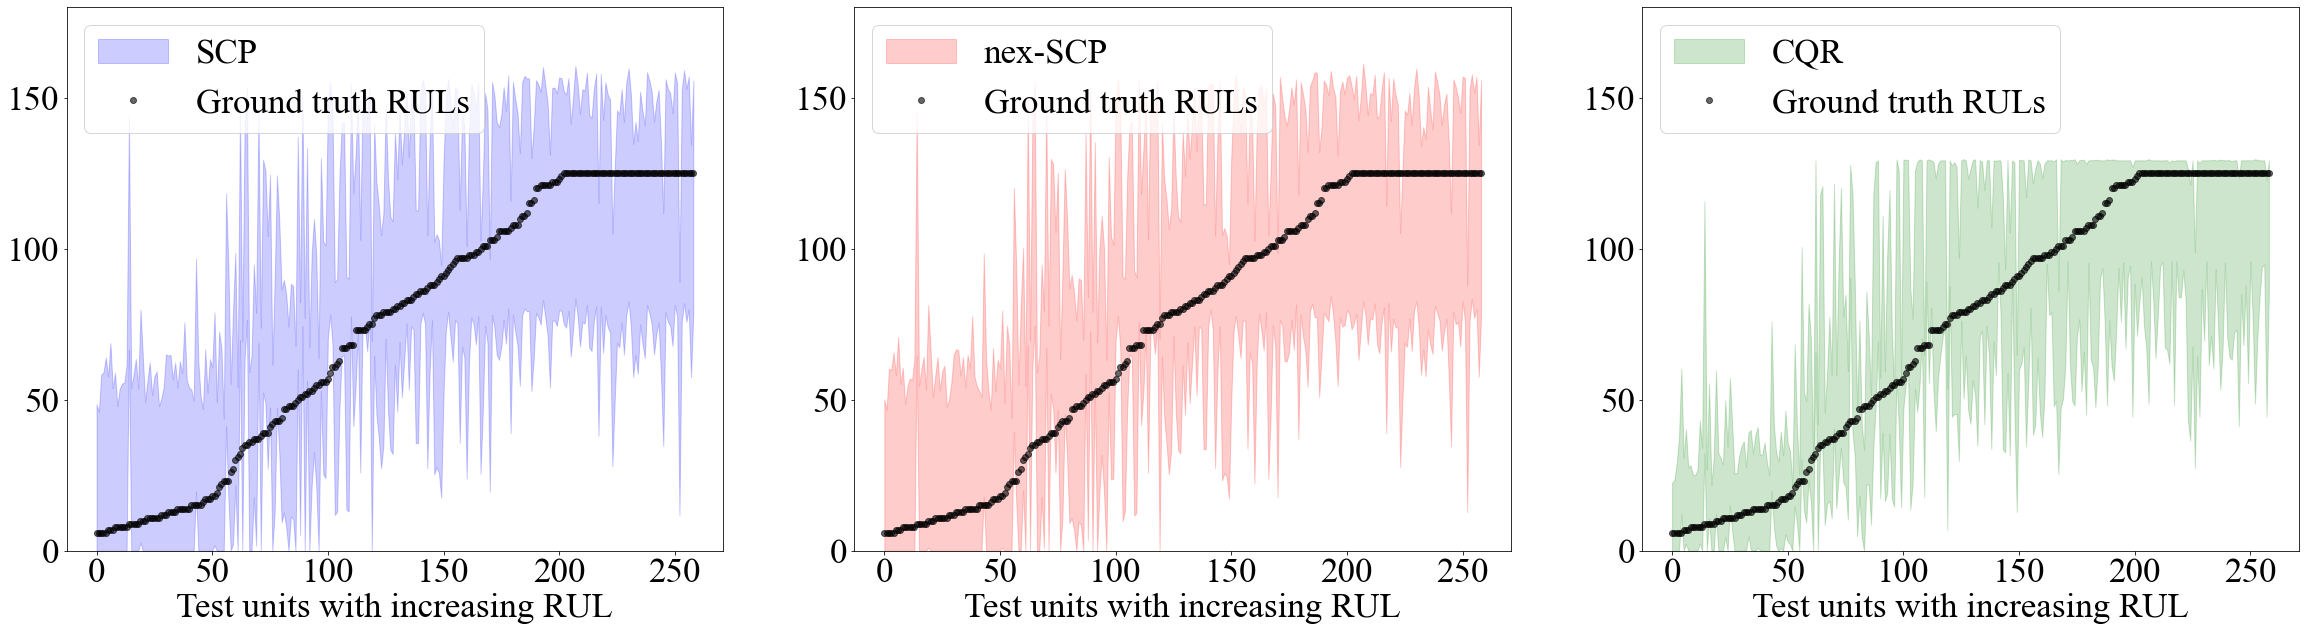

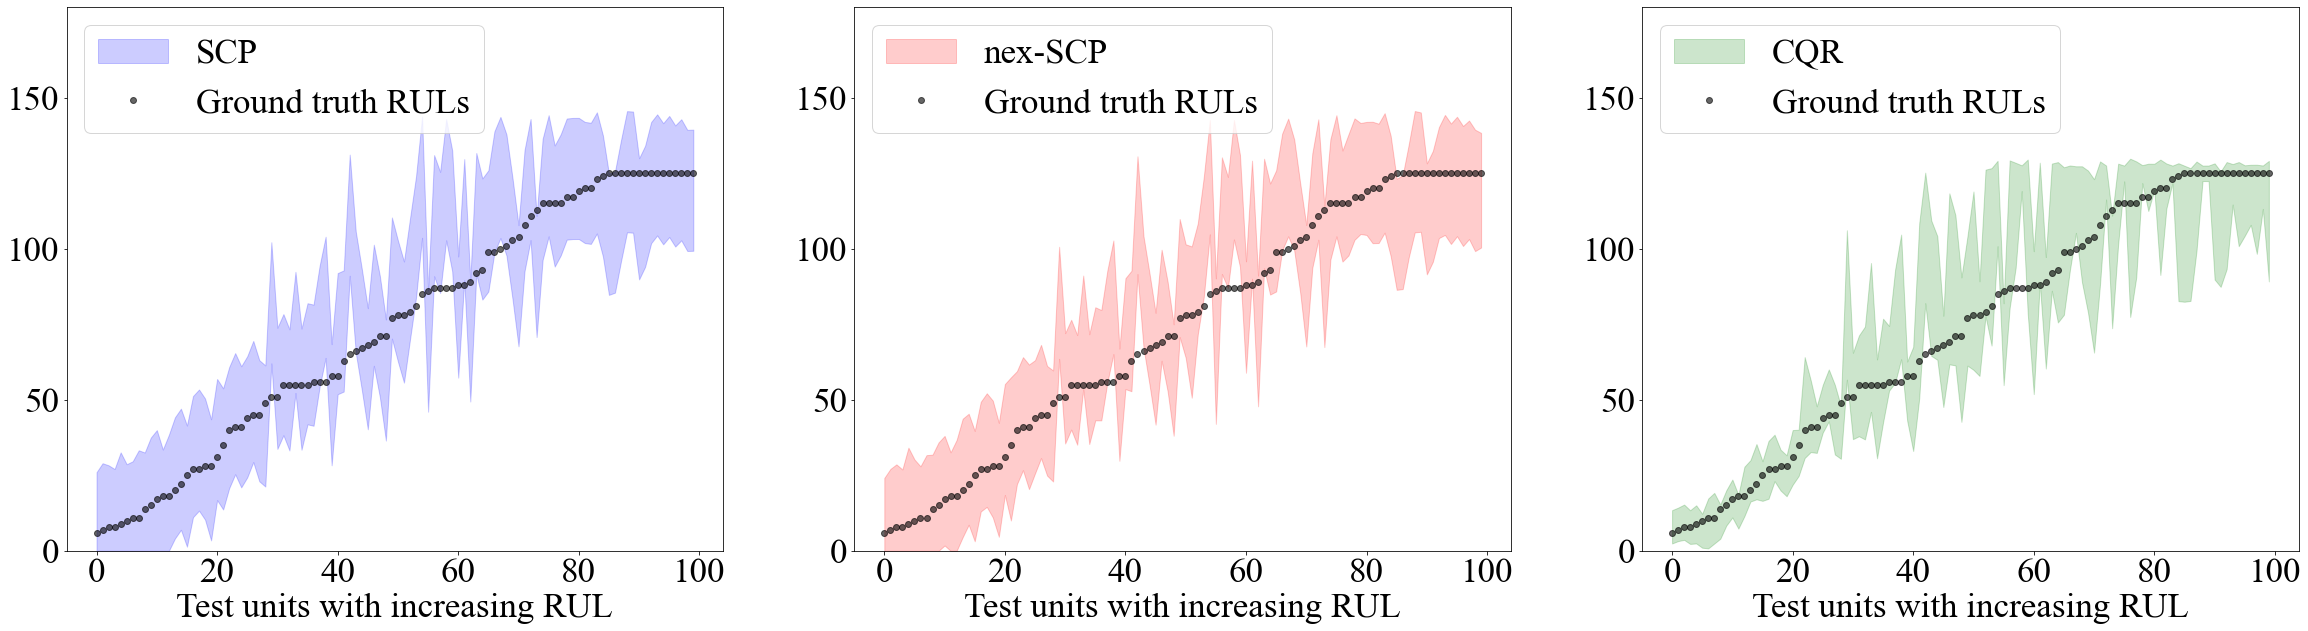

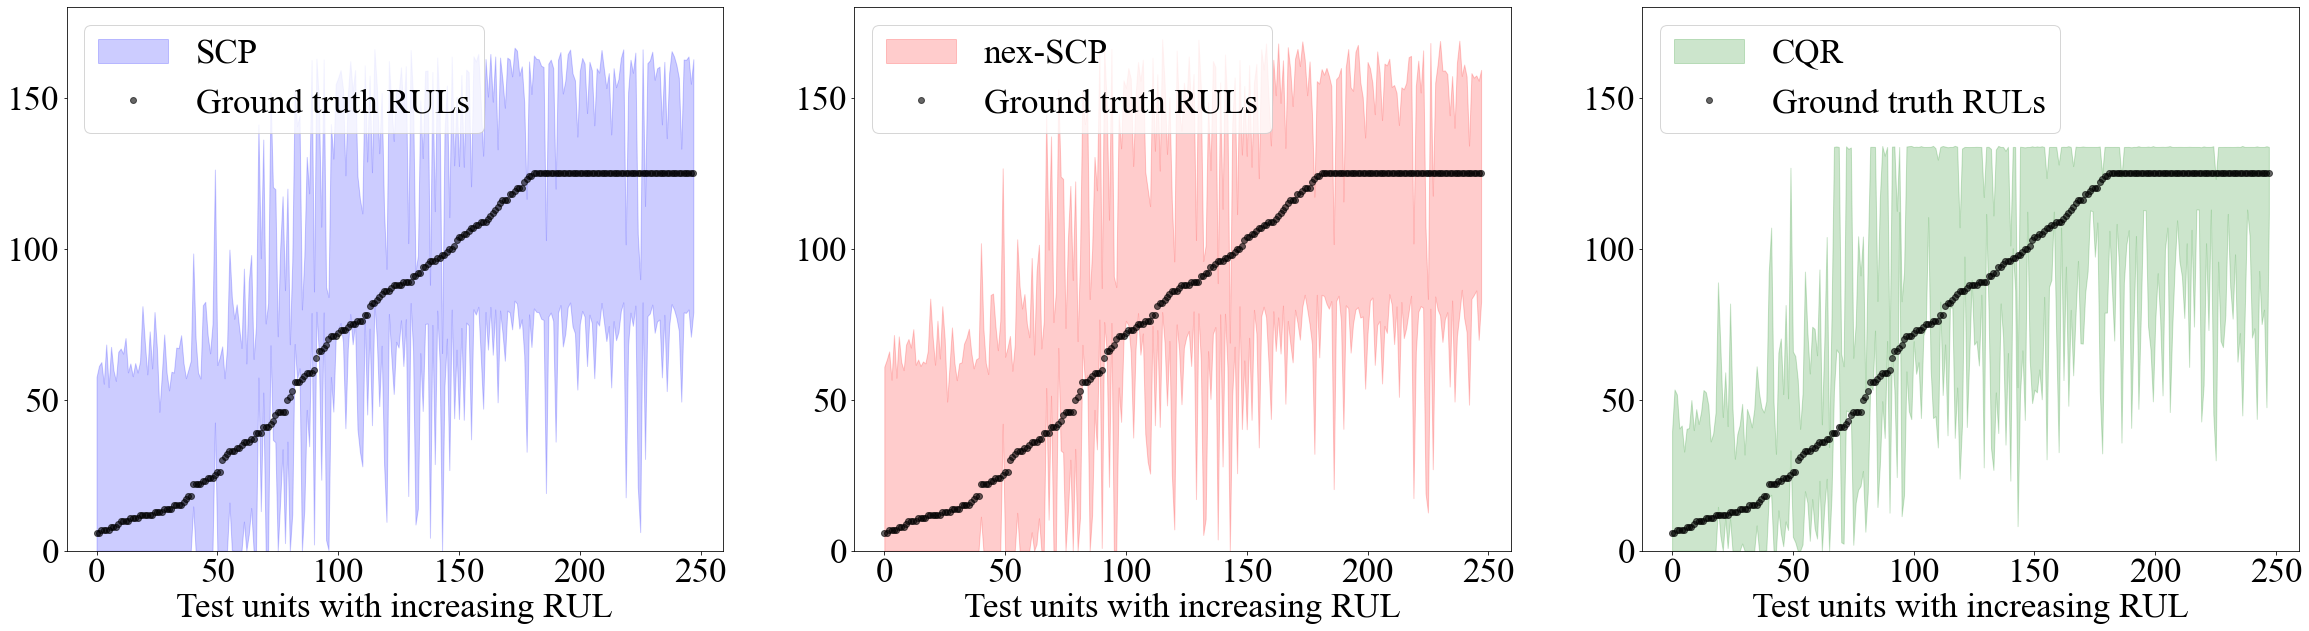

In [119]:
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    plot_sorted_targets_intervals(dataset_name, test_res)
    plt.savefig('result_figs\\test\\'+dataset_name+'.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Table

In [48]:
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    row = ""
    for m in ["SCP", "nex-SCP", "CQR"]:
        _, cvg, leng = compute_coverage_len(test_res[dataset_name]['y_test'], test_res[dataset_name][m][0], test_res[dataset_name][m][1])
        row = row + '%.2f' %leng + " & " + '%.2f' %(cvg*100) + " "
    print(row)

44.72 & 92.00 45.59 & 94.00 37.32 & 95.00 
72.59 & 89.19 73.68 & 90.35 54.96 & 88.42 
39.06 & 88.00 37.56 & 84.00 29.05 & 85.00 
78.96 & 90.32 80.28 & 90.73 58.91 & 90.73 


# Mean squared error and PHM score of the predicted lower bounds w.r.t. ground truth RULs 

In [122]:
from sklearn.metrics import mean_squared_error
import math
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    print(exp+1)
    for m in ["SCP", "nex-SCP", "CQR"]:
        RMSE = math.sqrt(mean_squared_error(test_res[dataset_name]['y_test'], test_res[dataset_name][m][0]))
        scor = PHM_score(test_res[dataset_name]['y_test'], test_res[dataset_name][m][0])
        print(f"{m}: RMSE = {RMSE}, PHM score = {scor}")

1
SCP: RMSE = 23.60105045373047, PHM score = 708.6231689453125
nex-SCP: RMSE = 23.9300649864121, PHM score = 731.8145751953125
CQR: RMSE = 22.71180822634244, PHM score = 684.2001953125
2
SCP: RMSE = 39.41516893268615, PHM score = 18598.84375
nex-SCP: RMSE = 39.62777247792891, PHM score = 18434.791015625
CQR: RMSE = 37.86146590645874, PHM score = 13183.55078125
3
SCP: RMSE = 19.734845878438048, PHM score = 422.23284912109375
nex-SCP: RMSE = 19.379805036731373, PHM score = 417.6658020019531
CQR: RMSE = 18.30036894212706, PHM score = 396.2329406738281
4
SCP: RMSE = 42.171555146526934, PHM score = 34678.51953125
nex-SCP: RMSE = 42.265974467131954, PHM score = 32348.0625
CQR: RMSE = 37.24920530559595, PHM score = 14490.943359375


# Mean squared error and PHM score of the DCNN predictions w.r.t. ground truth RULs 

In [124]:
for exp in range(4):
    dataset_name = "CMAPSS"+str(exp+1)
    proc_data, DCNN, MQDCNN = trained_models_dic[dataset_name]["data"], trained_models_dic[dataset_name]["DCNN"], trained_models_dic[dataset_name]["MQDCNN"]
    X_cal, y_cal, idx_cal = proc_data["calval"]["X"], proc_data["calval"]["y"], proc_data["calval"]["index"]
    X_test, y_test, idx_test = reform_test_data(proc_data["test"])

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_test = DCNN.predict(x=X_test, verbose=0)
    RMSE = math.sqrt(mean_squared_error(y_test, y_hat_test))
    scor = PHM_score(y_test, y_hat_test)
    print(f"{dataset_name}: RMSE = {RMSE}, PHM score = {scor}")

CMAPSS1: RMSE = 12.399351262996143, PHM score = 263.3770751953125
CMAPSS2: RMSE = 23.730477430553968, PHM score = 25810.41015625
CMAPSS3: RMSE = 13.04147237972211, PHM score = 375.12664794921875
CMAPSS4: RMSE = 23.3433865642726, PHM score = 6026.08447265625


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

dataset_name  = "CMAPSS1"
dataset = data.get_dataset(dataset_name, MinMaxScaler(feature_range=(-1, 1)))
split_dataset = pre.split_dataset(dataset, calval_size=0.1, random_state=0)
proc_dataset = pre.preprocess_split(split_dataset, scaler_factory=dataset["scaler_factory"], window_size=1, removable_cols=removable_cols, ignore_columns=ignore_columns)

X_train = proc_dataset["train"]["X"]
y_train = proc_dataset["train"]["y"]
X_calval = proc_dataset["calval"]["X"]
y_calval = proc_dataset["calval"]["y"]

param_grid = {'max_depth': [2, 5, 10, 15, None],
              'min_samples_split': [2, 5, 10]}
base_estimator = RandomForestRegressor(random_state=0)      
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(X_train, y_train)

In [11]:
methods = ["SCP", "nex-SCP", "CQR"]
colors = ["blue", "red", "green"]
for m,c in zip(methods, colors):
    print(m)
    print(c)

SCP
blue
nex-SCP
red
CQR
green


In [29]:
a = [(1,2), (3,4), (5,6)]
A = zip(*a)

In [30]:
B = np.stack(a)

In [31]:
B[:,0]

array([1, 3, 5])

In [4]:
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
ignore_columns = ["time", "os1", "os2", "os3"]

exp = '3'
dataset = data.get_dataset("CMAPSS"+exp, MinMaxScaler(feature_range=(-1, 1)))
split_dataset = pre.split_dataset(dataset, calval_size=0.15, random_state=0)
proc_dataset = pre.preprocess_split(split_dataset, scaler_factory=dataset["scaler_factory"], window_size=dataset["window_size"], removable_cols=removable_cols, ignore_columns=ignore_columns)

In [5]:
np.unique(split_dataset["train"]["id"])

array([  1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  13,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        75,  77,  78,  80,  81,  82,  83,  84,  85,  86,  88,  89,  90,
        91,  92,  95,  97,  98,  99, 100], dtype=int64)

In [6]:
np.unique(split_dataset["calval"]["id"])

array([ 3,  8, 14, 17, 27, 54, 55, 56, 74, 76, 79, 87, 93, 94, 96],
      dtype=int64)

In [7]:
np.unique(proc_dataset["train"]["id"])

array([  1,   2,   4,   5,   6,   7,   9,  10,  11,  12,  13,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        75,  77,  78,  80,  81,  82,  83,  84,  85,  86,  88,  89,  90,
        91,  92,  95,  97,  98,  99, 100], dtype=int64)

In [8]:
np.unique(proc_dataset["calval"]["id"])

array([ 3,  8, 14, 17, 27, 54, 55, 56, 74, 76, 79, 87, 93, 94, 96],
      dtype=int64)

In [9]:
proc_dataset["train"]["X"].shape

(18275, 30, 14, 1)

In [10]:
proc_dataset["calval"]["X"].shape

(3545, 30, 14, 1)

In [11]:
proc_dataset["train"]["X"].shape[0] + proc_dataset["calval"]["X"].shape[0]

21820

# train an ordinary mean estimator for SCP and nex-SCP

In [12]:
epochs = 100 # training epochs
optimizer = Adam(learning_rate=1e-3) # model optimizer

X_train = proc_dataset["train"]["X"]
y_train = proc_dataset["train"]["y"]
DCNN = create_model(window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
DCNN.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
DCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
36/36 [==============================] - 6s 148ms/step - loss: 7668.4634 - root_mean_squared_error: 87.5698
Epoch 2/100
36/36 [==============================] - 6s 158ms/step - loss: 6710.2441 - root_mean_squared_error: 81.9161
Epoch 3/100
36/36 [==============================] - 6s 169ms/step - loss: 6189.3574 - root_mean_squared_error: 78.6725
Epoch 4/100
36/36 [==============================] - 6s 181ms/step - loss: 5716.8228 - root_mean_squared_error: 75.6097
Epoch 5/100
36/36 [==============================] - 6s 168ms/step - loss: 5283.2603 - root_mean_squared_error: 72.6860
Epoch 6/100
36/36 [==============================] - 6s 178ms/step - loss: 4882.5825 - root_mean_squared_error: 69.8755
Epoch 7/100
36/36 [==============================] - 6s 170ms/step - loss: 4510.8188 - root_mean_squared_error: 67.1626
Epoch 8/100
36/36 [==============================] - 6s 167ms/step - loss: 4166.8770 - root_mean_squared_error: 64.5514
Epoch 9/100
36/36 [=====================

# train a quantile estimator for CQR

In [13]:
alpha = 0.4
epochs = 100
quantiles = [alpha/2, 1 - alpha/2]
loss_func = MultiQuantileLoss(quantiles=quantiles)

MQDCNN = create_MQDCNN(quantiles=quantiles, window_size=dataset["window_size"], feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
MQDCNN.compile(optimizer=optimizer, loss=loss_func, metrics=[RootMeanSquaredError()])
MQDCNN.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/100
36/36 [==============================] - 7s 185ms/step - loss: 72.0766 - q0_loss: 16.1331 - q1_loss: 55.9435 - q0_root_mean_squared_error: 89.6892 - q1_root_mean_squared_error: 80.4227
Epoch 2/100
36/36 [==============================] - 7s 188ms/step - loss: 55.8940 - q0_loss: 13.1748 - q1_loss: 42.7192 - q0_root_mean_squared_error: 74.2886 - q1_root_mean_squared_error: 63.8062
Epoch 3/100
36/36 [==============================] - 7s 190ms/step - loss: 45.6014 - q0_loss: 11.0702 - q1_loss: 34.5312 - q0_root_mean_squared_error: 63.5949 - q1_root_mean_squared_error: 53.0525
Epoch 4/100
36/36 [==============================] - 7s 187ms/step - loss: 38.1910 - q0_loss: 9.5931 - q1_loss: 28.5979 - q0_root_mean_squared_error: 55.3585 - q1_root_mean_squared_error: 44.9792
Epoch 5/100
36/36 [==============================] - 7s 188ms/step - loss: 32.4923 - q0_loss: 8.5167 - q1_loss: 23.9756 - q0_root_mean_squared_error: 48.8316 - q1_root_mean_squared_error: 38.4639
Epoch 6/100
36/36

# Checking whether calibration works fine

In [18]:
R = 50
rho = 0.99
alpha = 0.1
SCP = [] #Split conformal prediction
nex_SCP = [] #non-exchangeable Split conformal prediction
CQR = [] #conformalized quantile regression


for r in range(R):
    val_idx, cal_idx = pre.split_by_group(X=proc_dataset["calval"]["X"], groups=proc_dataset["calval"]["id"], n_splits=1, test_size=0.5, random_state=r)
    X_val, X_cal = proc_dataset["calval"]["X"][val_idx], proc_dataset["calval"]["X"][cal_idx]
    y_val, y_cal = proc_dataset["calval"]["y"][val_idx], proc_dataset["calval"]["y"][cal_idx]
    idx_val, idx_cal = proc_dataset["calval"]["index"][val_idx], proc_dataset["calval"]["index"][cal_idx]
    id_val, id_cal = proc_dataset["calval"]["id"][val_idx], proc_dataset["calval"]["id"][cal_idx]

    y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
    y_hat_val = DCNN.predict(x=X_val, verbose=0)
    scores = np.abs(y_cal - y_hat_cal) 
    q = compute_quantile(scores, alpha)
    q_array = compute_quantiles_nex(rho, scores, idx_val, idx_cal, alpha)
    SCP.append(compute_coverage_len(y_val, y_hat_val-q, y_hat_val+q))
    nex_SCP.append(compute_coverage_len(y_val, y_hat_val-q_array, y_hat_val+q_array))

    y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
    y_hat_val_CQR = MQDCNN.predict(x=X_val, verbose=0)
    scores_low = y_hat_cal_CQR[0] - y_cal
    scores_high = y_cal - y_hat_cal_CQR[1] 
    scores_CQR = np.maximum(scores_low, scores_high)
    q_CQR = compute_quantile(scores_CQR, alpha)
    CQR.append(compute_coverage_len(y_val, y_hat_val_CQR[0] - q_CQR, y_hat_val_CQR[1] + q_CQR))
    


left_coverage_nex_SCP, coverage_nex_SCP, avg_length_nex_SCP =  zip(*nex_SCP)
left_coverage_SCP, coverage_SCP, avg_length_SCP =  zip(*SCP)
left_coverage_CQR, coverage_CQR, avg_length_CQR =  zip(*CQR)

(array([ 1.,  1.,  3.,  2.,  8., 10., 13.,  4.,  6.,  2.]),
 array([25.40931 , 26.440165, 27.47102 , 28.501875, 29.53273 , 30.563585,
        31.59444 , 32.625298, 33.65615 , 34.687004, 35.71786 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

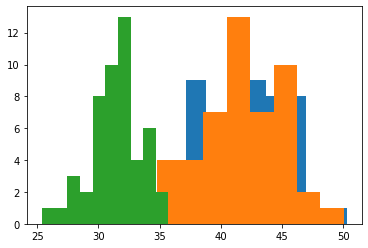

In [19]:
plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)

In [20]:
print(f"SCP: {np.mean(avg_length_SCP)}, nex-SCP: {np.mean(avg_length_nex_SCP)}, CQR: {np.mean(avg_length_CQR)} ")

SCP: 41.720252990722656, nex-SCP: 41.434024810791016, CQR: 31.383874893188477 


(array([ 1.,  2.,  1.,  5.,  3.,  9., 12., 11.,  4.,  2.]),
 array([0.8213892 , 0.8354076 , 0.849426  , 0.86344441, 0.87746281,
        0.89148122, 0.90549962, 0.91951802, 0.93353643, 0.94755483,
        0.96157324]),
 <BarContainer object of 10 artists>)

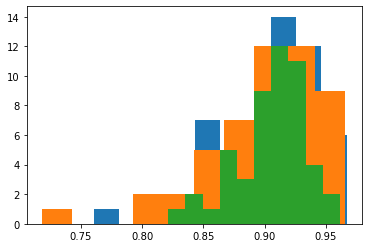

In [21]:
plt.hist(coverage_SCP)
plt.hist(coverage_nex_SCP)
plt.hist(coverage_CQR)

In [22]:
print(f"SCP: {np.mean(coverage_SCP)}, nex-SCP: {np.mean(coverage_nex_SCP)}, CQR: {np.mean(coverage_CQR)} ")

SCP: 0.9014602342707579, nex-SCP: 0.9022295458742211, CQR: 0.9049742942893911 


In [23]:
X_test, y_test, idx_test = [], [], []
for id in np.unique(proc_dataset["test"]["id"]):
    X_test.append(proc_dataset["test"]["X"][proc_dataset["test"]["id"]==id][-1])
    y_test.append(proc_dataset["test"]["y"][proc_dataset["test"]["id"]==id][-1])
    idx_test.append(proc_dataset["test"]["index"][proc_dataset["test"]["id"]==id][-1])

In [24]:
X_test = np.array(X_test)
y_test = np.array(y_test)
idx_test = np.array(idx_test)

In [25]:
X_test.shape

(100, 30, 14, 1)

# Now calibrate using calval data and test it on test  

In [30]:
alpha = 0.1

X_cal, y_cal, idx_cal = proc_dataset["calval"]["X"], proc_dataset["calval"]["y"], proc_dataset["calval"]["index"]
y_hat_cal = DCNN.predict(x=X_cal, verbose=0)
y_hat_test = DCNN.predict(x=X_test, verbose=0)
scores = np.abs(y_cal - y_hat_cal) 
q = compute_quantile(scores, alpha)
q_array = compute_quantiles_nex(rho, scores, idx_test, idx_cal, alpha)


print(compute_coverage_len(y_test, y_hat_test - q, y_hat_test + q))
print(compute_coverage_len(y_test, y_hat_test  - q_array, y_hat_test  + q_array))

y_hat_cal_CQR = MQDCNN.predict(x=X_cal, verbose=0)
y_hat_test_CQR = MQDCNN.predict(x=X_test, verbose=0)
scores_low = y_hat_cal_CQR[0] - y_cal
scores_high = y_cal - y_hat_cal_CQR[1] 
scores_CQR = np.maximum(scores_low, scores_high)
q_CQR = compute_quantile(scores_CQR, alpha)

print(compute_coverage_len(y_test, y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR))

(0.9, 0.88, 41.198154)
(0.91, 0.89, 40.954502)
(0.87, 0.84, 33.024723)


In [27]:
from cProfile import label
import matplotlib

def plot_sorted(exp_num, methods, y_true):
    
    sorted_y_idx = y_true.argsort(axis=0)
    sorted_y = y_true[sorted_y_idx.reshape(-1)]
    fig = plt.figure(figsize=(40, 10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 35
    i = 1
    colors = ["blue", "red", "green"]
    for m in methods:
        lower = methods[m][0]
        upper = methods[m][1]
        sorted_low = np.maximum(0,lower[sorted_y_idx])
        sorted_up = upper[sorted_y_idx]
        ax = fig.add_subplot(1,3,i)
        ax.fill_between(range(len(sorted_y)), sorted_low.reshape(-1), sorted_up.reshape(-1), color=colors[i-1], alpha=0.1, label=m)
        ax.plot(range(len(sorted_y)), sorted_y, 'ok', label="True labels", alpha=0.4)
        plt.ylim([0,180])
        plt.xlabel('Test units with increasing RUL')
        plt.legend(loc='lower right')
        i = i + 1
    plt.savefig('result_figs\\'+str(exp_num)+'.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [28]:
methods = {"SCP" : (y_hat_test - q, y_hat_test + q),
           "nex-SCP" : (y_hat_test  - q_array, y_hat_test  + q_array), 
           "CQR" : (y_hat_test_CQR[0] - q_CQR, y_hat_test_CQR[1] + q_CQR)
           }

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


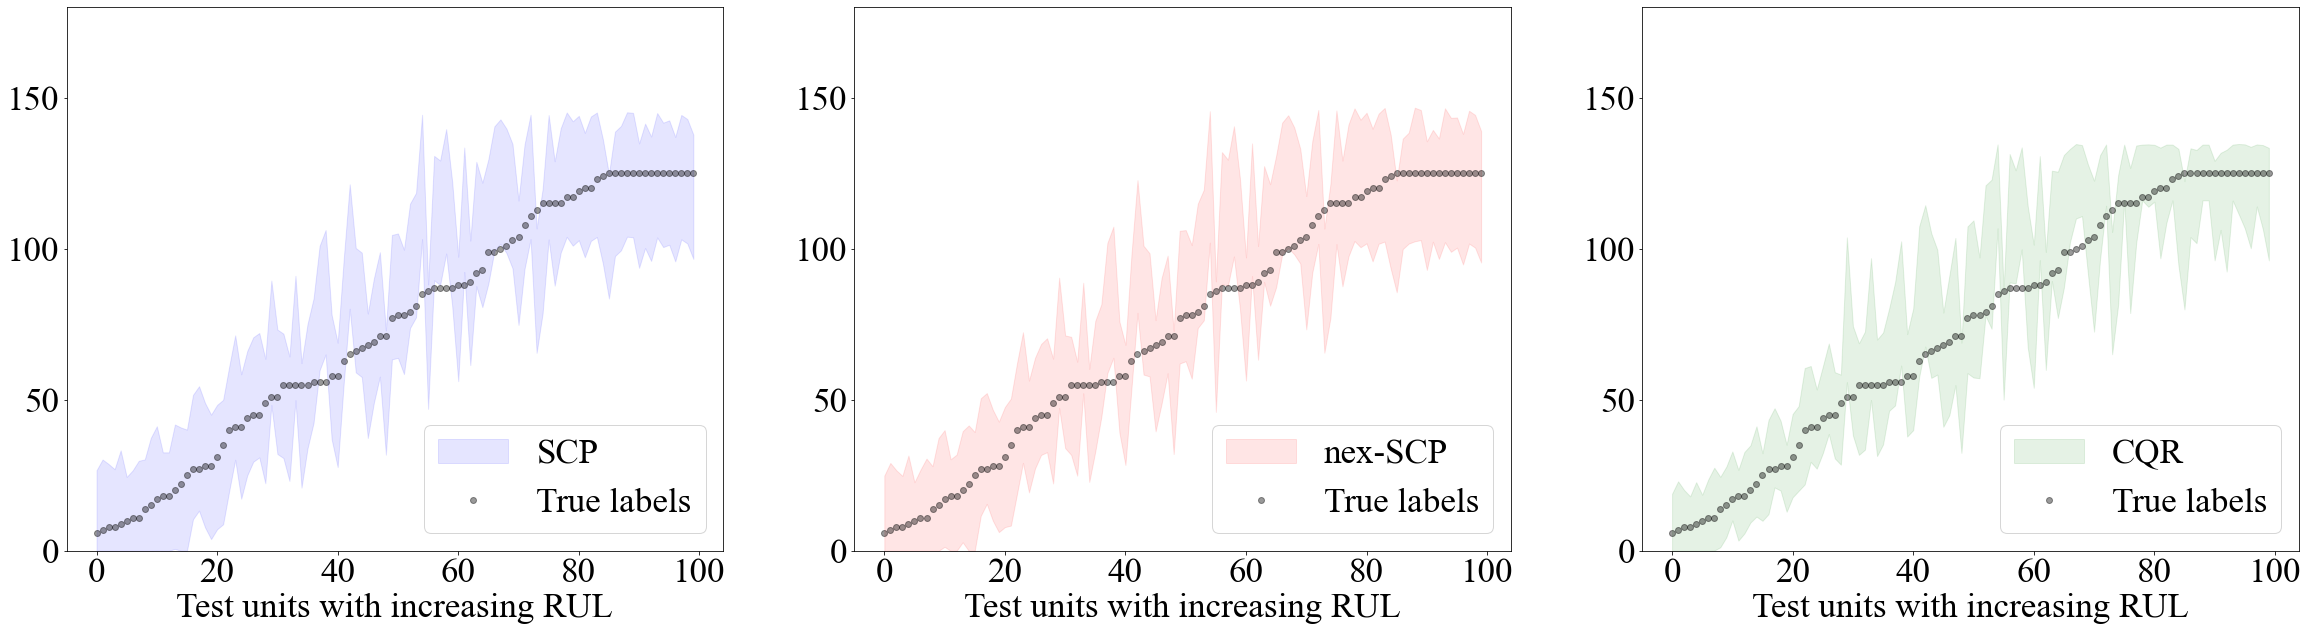

In [29]:
plot_sorted(exp, methods, y_test)

In [ ]:
import matplotlib

plt.hist(avg_length_SCP)
plt.hist(avg_length_nex_SCP)
plt.hist(avg_length_CQR)
font = {'fontname':'Times New Roman'}
matplotlib.rc('font', **font)
plt.xlabel('average coverage')

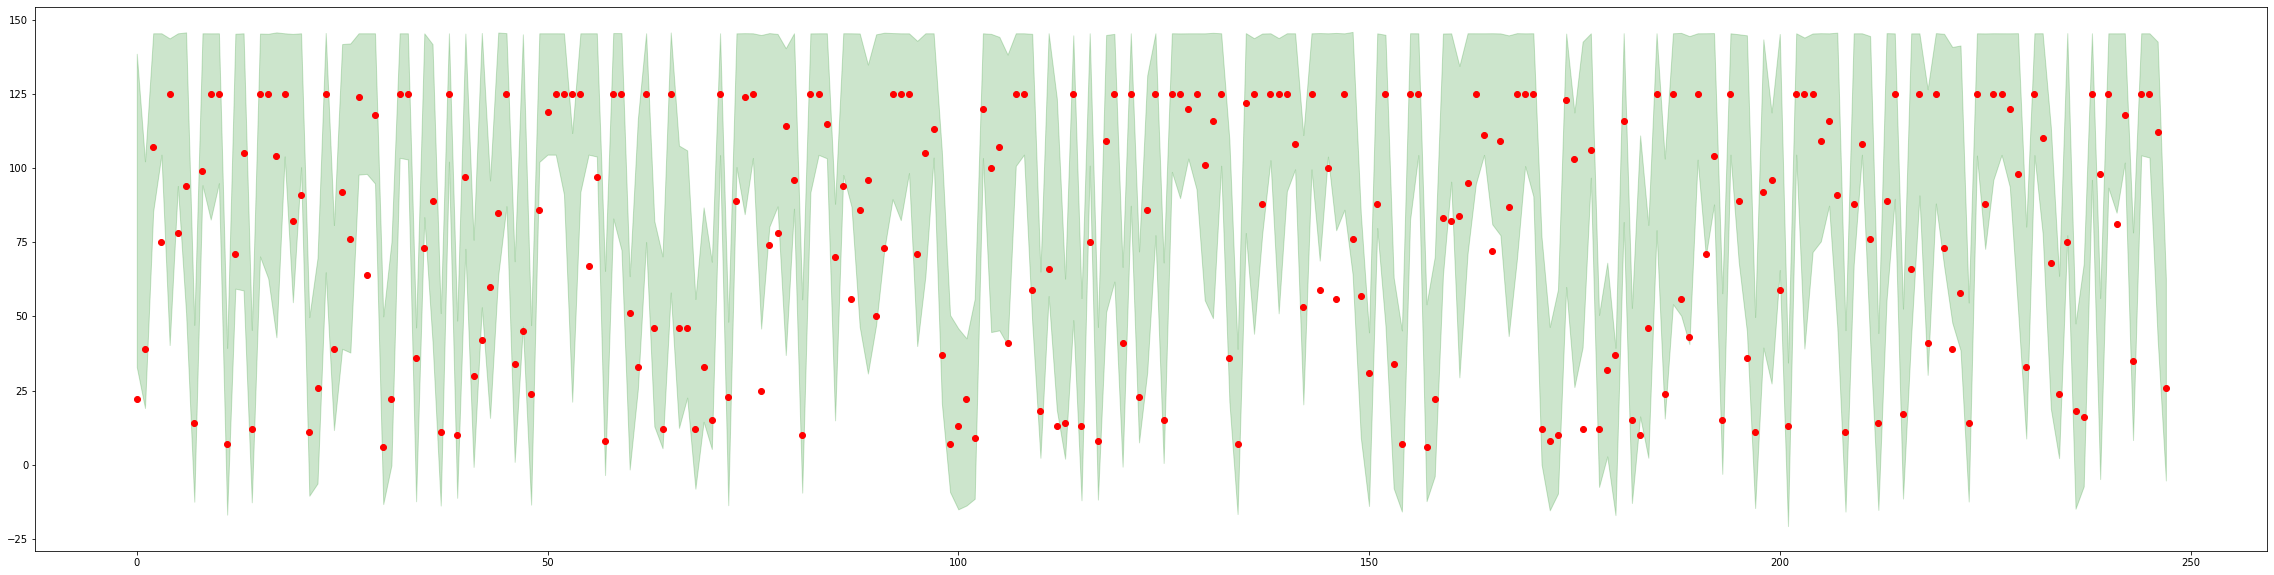

In [85]:
plt.figure(figsize=(40, 10))
y_low_CQR = y_hat_test_CQR[0] - q_CQR
y_high_CQR = y_hat_test_CQR[1] + q_CQR
plt.fill_between(range(len(y_hat_test_CQR[0])), y_low_CQR.reshape(-1), y_high_CQR.reshape(-1), color='green', alpha=0.2)
plt.plot(range(len(y_hat_test_CQR[0])), y_test, 'or')

In [105]:
sorted_y_idx = y_test.argsort(axis=0)
sorted_y = y_test[sorted_y_idx.reshape(-1)]
sorted_y

array([[  6.],
       [  6.],
       [  7.],
       [  7.],
       [  7.],
       [  7.],
       [  8.],
       [  8.],
       [  8.],
       [  9.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 10.],
       [ 11.],
       [ 11.],
       [ 11.],
       [ 11.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 12.],
       [ 13.],
       [ 13.],
       [ 13.],
       [ 13.],
       [ 14.],
       [ 14.],
       [ 14.],
       [ 14.],
       [ 15.],
       [ 15.],
       [ 15.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 18.],
       [ 22.],
       [ 22.],
       [ 22.],
       [ 22.],
       [ 23.],
       [ 23.],
       [ 24.],
       [ 24.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 26.],
       [ 30.],
       [ 31.],
       [ 32.],
       [ 33.],
       [ 33.],
       [ 33.],
       [ 34.],
       [ 34.],
       [ 35.],
       [ 36.],
       [ 36.],
       [ 36.],
       [ 37.],
       [ 37.],
       [ 3

In [107]:
sorted_y_low = y_low_CQR[sorted_y_idx.reshape(-1)]

sorted_y_low

array([[-12.26948   ],
       [-13.251315  ],
       [ -9.207292  ],
       [-16.616743  ],
       [-15.756405  ],
       [-16.811127  ],
       [-11.728525  ],
       [-15.361374  ],
       [ -3.4782906 ],
       [-11.460392  ],
       [-11.135793  ],
       [ -9.701668  ],
       [ 16.277931  ],
       [ -9.404545  ],
       [-13.738728  ],
       [-15.778656  ],
       [-14.597839  ],
       [-10.442679  ],
       [-12.6615715 ],
       [ 39.5233    ],
       [  0.13369751],
       [ -8.060177  ],
       [  5.5707283 ],
       [ -7.4631205 ],
       [ 18.374641  ],
       [-11.980366  ],
       [-20.6687    ],
       [-15.023525  ],
       [-15.228604  ],
       [  2.0397263 ],
       [-12.45227   ],
       [-12.3923025 ],
       [  0.5855713 ],
       [-12.889482  ],
       [ -3.0718193 ],
       [  5.3039665 ],
       [ -7.2999086 ],
       [-11.3939085 ],
       [-14.8085    ],
       [  2.347454  ],
       [ 32.90305   ],
       [ -0.15514374],
       [ -3.8498573 ],
       [-13

In [110]:
sorted_y_high = y_high_CQR[sorted_y_idx.reshape(-1)]

sorted_y_high

array([[138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],
       [138.52225],


In [113]:
sorted_y_idx.reshape(-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [117]:
sorted_y_idx = y_test.argsort()

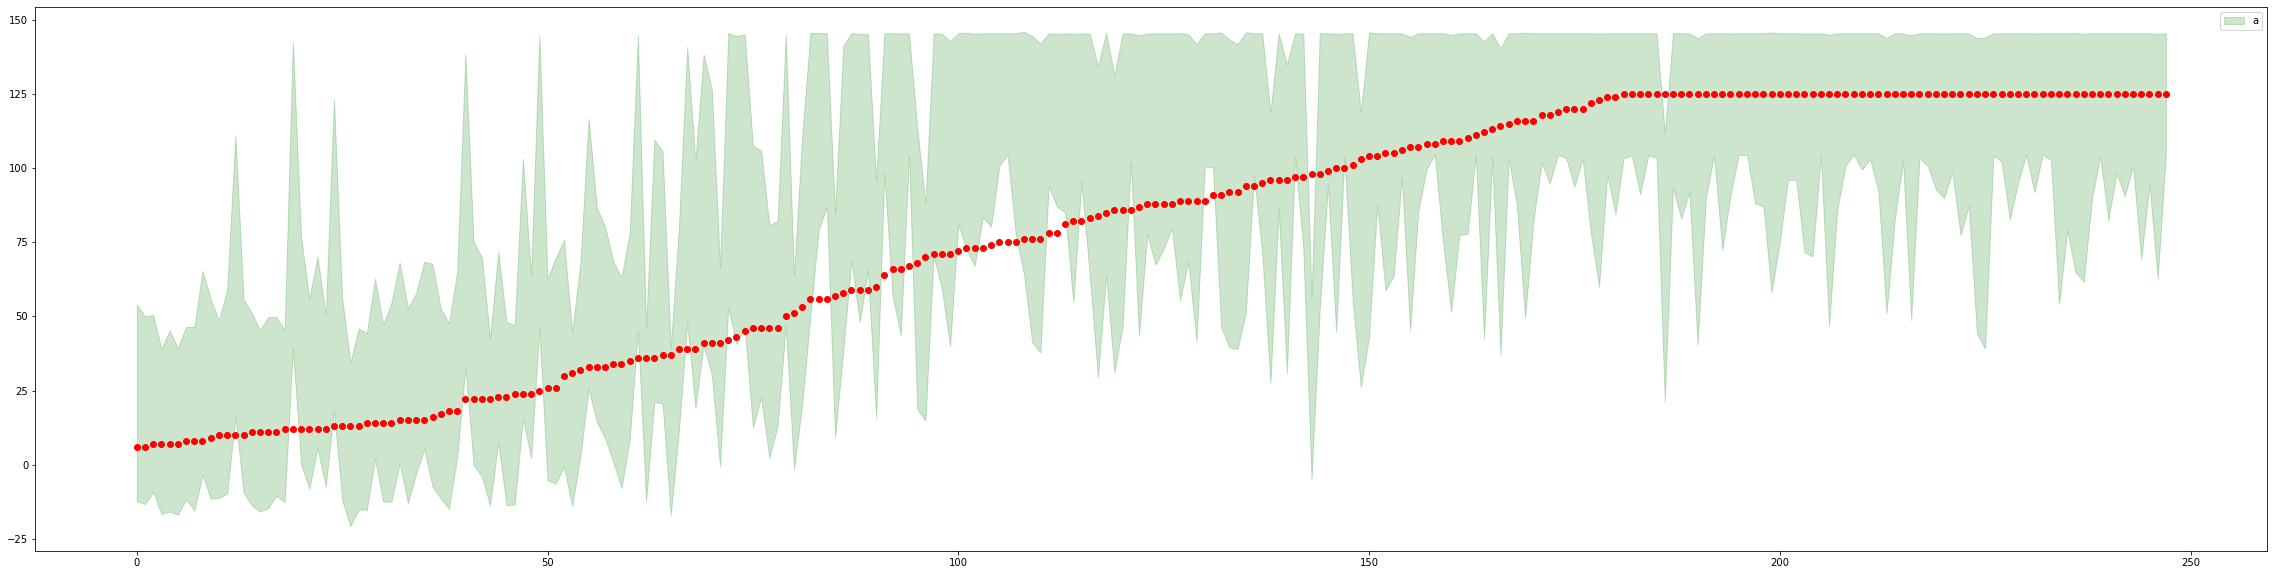

In [125]:
from cProfile import label


plt.figure(figsize=(40, 10))
sorted_y_idx = y_test.argsort(axis=0)
sorted_y = y_test[sorted_y_idx.reshape(-1)]
sorted_y_low = y_low_CQR[sorted_y_idx]
sorted_y_high = y_high_CQR[sorted_y_idx]
plt.fill_between(range(len(y_hat_test_CQR[0])), sorted_y_low.reshape(-1), sorted_y_high.reshape(-1), color='green', alpha=0.2, label='a')
plt.plot(range(len(y_hat_test_CQR[0])), sorted_y, 'or')
plt.legend()

In [164]:
y_hat_test_CQR[0].reshape(-1).shape

(37742,)

In [176]:
proc_dataset2["test"]["index"][proc_dataset2["test"]["id"]==50]

array([9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467,
       9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478,
       9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489,
       9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500,
       9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511,
       9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522,
       9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533,
       9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544,
       9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555,
       9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566,
       9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577,
       9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588,
       9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599,
       9600, 9601, 9602, 9603, 9604, 9605, 9606, 96

In [39]:
np.arange(50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [3]:
a.shape

(50,)

In [4]:
b = np.arange(70)

In [8]:
c = [a,b]
d = np.vstack(c)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 1 has size 70

In [9]:
d.shape

(120,)